
# Training a Custom Model Using Sorting Analyzer

In this tutorial, we show how to train your own machine learning classifier for automated spike-sorting curation with UnitRefine. Pre-trained models work well for most datasets, but training a custom model can yield better performance for specific experimental conditions or recording setups.

We demonstrates how to train a custom machine learning classifier for automated spike sorting curation using **Sorting Analyzer**.

In [ ]:
! pip install spikeinterface[full]

In [1]:
import spikeinterface as si
import spikeinterface.curation as sc
import spikeinterface.widgets as sw

print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.102.3


For this tutorial, we will use simulated data to create - **recording** and - **sorting objects**. We'll create two instances since we recommend to use at least two recordings to create a custom machine learning classifier.

We combine both sortings using `si.aggregate_units()` to create a dataset.

**For real applications:** Replace this simulated data with your actual experimental recordings. You should:
1. [Load your own recordings](https://spikeinterface.readthedocs.io/en/latest/modules/extractors.html)
2. [Perform spike sorting](https://spikeinterface.readthedocs.io/en/latest/modules/sorters.html) 


In [2]:
print("Generating simulated data...")

recording, sorting_1 = si.generate_ground_truth_recording(
    num_channels=4, 
    seed=1, 
    num_units=10,
    durations=[300.0], 
    sampling_frequency=30000
)

_, sorting_2 = si.generate_ground_truth_recording(
    num_channels=4, 
    seed=2, 
    num_units=10,
    durations=[300.0],
    sampling_frequency=30000
)

# Combine both sortings
both_sortings = si.aggregate_units([sorting_1, sorting_2])

Generating simulated data...


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\spikeinterface\core\generate.py:2258: UserWarning: generate_unit_locations(): no solution for minimum_distance=20 and max_iteration=100
  warnings.warn(f"generate_unit_locations(): no solution for {minimum_distance=} and {max_iteration=}")


UnitRefine models are trained on quantitative features that describe unit quality. These features come from two main sources:

- **[Quality metrics](https://spikeinterface.readthedocs.io/en/latest/modules/qualitymetrics.html)**: Measures like ISI violations, firing rate, presence ratio, signal-to-noise ratio
- **[Template metrics](https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html#template-metrics)**: Waveform characteristics like peak-to-trough ratio, spatial spread, velocity

These metrics are computed using a `SortingAnalyzer` object, which efficiently handles the analysis pipeline. Learn more about [SortingAnalyzer here](https://spikeinterface.readthedocs.io/en/stable/tutorials/core/plot_4_sorting_analyzer.html).

In [3]:
# Create SortingAnalyzer
analyzer = si.create_sorting_analyzer( sorting=both_sortings, recording=recording, sparse=False)

# Compute all extensions required by the model
extensions_to_compute = ['noise_levels', 'random_spikes',
                        'waveforms','templates',
                        'spike_locations','spike_amplitudes',
                        'correlograms', 'principal_components',
                        'quality_metrics', 'template_metrics']

analyzer.compute(extensions_to_compute)




# Display summary of computed metrics
quality_metrics = analyzer.get_extension('quality_metrics').get_data()
template_metrics = analyzer.get_extension('template_metrics').get_data()

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/20 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\scipy\stats\_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\scipy\stats\_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\scipy\stats\_stats_py.py:10750: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Compute : spike_locations + spike_amplitudes (no parallelization):   0%|          | 0/300 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/20 [00:00<?, ?it/s]

Now we need to create labels for our training data. In real applications, each recording would contain both good and bad units mixed together. To simulate this more realistic scenario, we'll randomly assign labels to units from both recordings.

**Note:** In real applications, these labels would come from manual curation using tools like UnitRefine GUI.

In [4]:
# Create realistic mixed labels for both recordings
import numpy as np
import random

unit_ids = both_sortings.get_unit_ids()
total_units = len(unit_ids)

np.random.seed(42)

# Create mixed labels - approximately 60% good, 40% bad (realistic ratio)
n_good = int(total_units * 0.6)
n_bad = total_units - n_good

labels = ['good'] * n_good + ['bad'] * n_bad
# Shuffle to create random distribution across both recordings
random.shuffle(labels)
# Show label distribution for each recording
sorting_1_labels = labels[:10]  # First 10 units from sorting_1
sorting_2_labels = labels[10:]  # Last 10 units from sorting_2

print(f"\nLabel distribution by recording:")
print(f"  - Recording 1 (units 0-9): {sorting_1_labels.count('good')} good, {sorting_1_labels.count('bad')} bad")
print(f"  - Recording 2 (units 10-19): {sorting_2_labels.count('good')} good, {sorting_2_labels.count('bad')} bad")



Label distribution by recording:
  - Recording 1 (units 0-9): 6 good, 4 bad
  - Recording 2 (units 10-19): 6 good, 4 bad


## Train the Classifier

Now we train a machine learning classifier to distinguish between good and bad units based on the computed metrics. UnitRefine uses an automated pipeline that tests different model configurations to find the best performing combination.


 Model Selection: Tests multiple algorithms (Random Forest, Gradient Boosting, Logistic Regression, etc.)

Data Preprocessing: 
- **Imputation**: Handles missing values using strategies like median, mean, or mode
- **Feature scaling**: Normalizes metrics using StandardScaler, RobustScaler, etc.

For improved model performance and generalization, it's recommended to:
- Use atleast 2 datasets from different recording sessions
- Include diverse experimental conditions (different animals, brain regions, etc.)



In [5]:
folder = "data"

trainer = sc.train_model(
    mode="analyzers",                           # Use SortingAnalyzer objects as input
    labels=[labels],                            # List of label arrays (one per analyzer)
    analyzers=[analyzer],                       # List of SortingAnalyzer objects
    folder=folder,                              # Output directory for model files
     metric_names=None,                         # Feature selection (None = use all computed metrics)
    imputation_strategies=["median"],           # How to handle missing values
    scaling_techniques=["standard_scaler"],     # Feature normalization methods
    classifiers=["RandomForestClassifier"],     # many lassifier algorithms can be added here
    overwrite=True                              # Overwrite existing model folder
)

# the best performing model
best_model = trainer.best_pipeline

c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\spikeinterface\curation\train_manual_curation.py:247: UserWarning: No metric_names provided, using all metrics calculated by the analyzers
  warnings.warn("No metric_names provided, using all metrics calculated by the analyzers")
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 150] was inferred to Integer(low=100, high=150, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 150), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 4), prior=None). See the 

Running RandomForestClassifier with imputation median and scaling StandardScaler()


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('balanced_subsample'), np.str_('entropy'), np.int64(4), np.int64(4), np.int64(100)] before, using random point ['balanced_subsample', 'gini', np.int64(3), np.int64(4), np.int64(149)]
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('balanced_subsample'), np.str_('entropy'), np.int64(4), np.int64(4), np.int64(100)] before, using random point ['balanced', 'entropy', np.int64(3), np.int64(2), np.int64(125)]
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('balanced_subsample'), np.str_('entropy'), np.int64(4), np.int64(4), np.int64(100)] before, using random point ['balanced', 'entropy', np.int6

In [6]:
best_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy', min_samples_leaf=4,
                                        min_samples_split=4, n_estimators=107,
                                        random_state=np.int64(458509528)))])

## Training Results and Model Files

The training process creates several important files in the output folder:

### Generated Files:

- **`best_model.skops`**: The trained classifier in skops format (secure alternative to pickle)
- **`model_info.json`**: Metadata including training parameters, feature names, and model configuration  
- **`model_accuracies.csv`**: Performance metrics (accuracy, precision, recall) for all tested combinations
- **`labels.csv`**: The training labels used
- **`training_data.csv`**: The feature matrix used for training

### 🔍 About skops Format:
[Skops](https://skops.readthedocs.io/en/stable/index.html) is a secure, Python-native alternative to pickle that's designed specifically for scikit-learn models. It prevents code execution vulnerabilities while maintaining compatibility.


In [11]:
import pandas as pd
from pathlib import Path

accuracies = pd.read_csv(Path(folder) / "model_accuracies.csv", index_col=0)

print(f"results")
print(accuracies.round(3))

results
          classifier name imputation_strategy  scaling_strategy  \
0  RandomForestClassifier              median  StandardScaler()   

   balanced_accuracy  precision  recall  model_id  \
0               0.25      0.167    0.25         0   

                                         best_params  
0  OrderedDict([('class_weight', 'balanced_subsam...  


## Step 5: Analyze Feature Importance

Now let's examine which metrics the model found most useful for distinguishing between good and bad units. Feature importance analysis helps us understandn which metrics matter most** for automated curation.

**Note on Performance**: With randomly assigned labels, the model performance may vary since there's no systematic relationship between the metrics and labels. In real applications with proper manual curation, you'd typically see clearer feature importance patterns that reflect actual unit quality indicators.

🔍 Top 10 Most Important Features:
 1. drift_std                 0.0997
 2. drift_ptp                 0.0952
 3. sd_ratio                  0.0762
 4. nn_hit_rate               0.0621
 5. amplitude_median          0.0571
 6. amplitude_cutoff          0.0571
 7. sync_spike_2              0.0476
 8. firing_rate               0.0424
 9. d_prime                   0.0381
10. amplitude_cv_median       0.0381


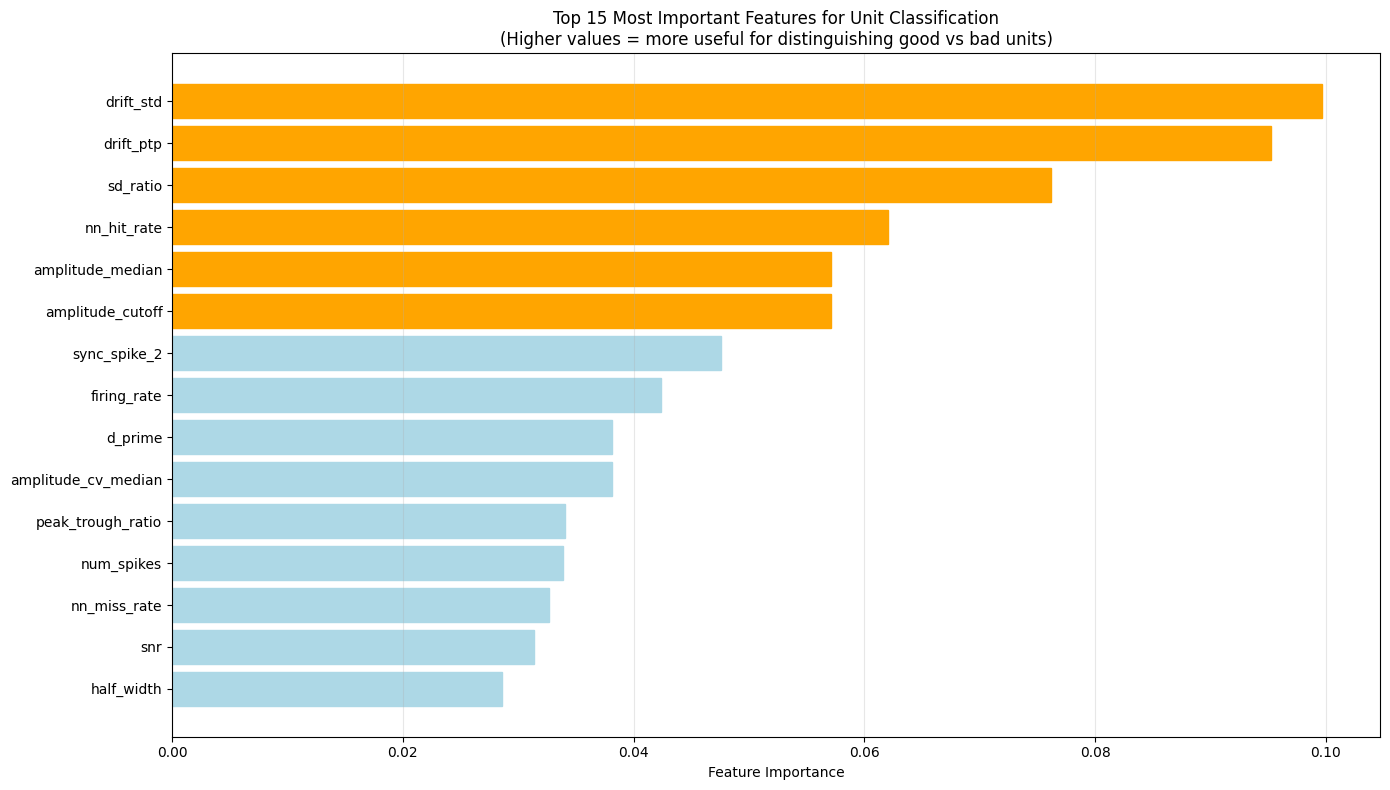

In [13]:
import matplotlib.pyplot as plt

importances = best_model.named_steps['classifier'].feature_importances_
feature_names = best_model.feature_names_in_

# Create a DataFrame for easier analysis
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Display top 10 most important features
print(f"🔍 Top 10 Most Important Features:")
print("=" * 50)
for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
    print(f"{i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

# Plot feature importances
plt.figure(figsize=(14, 8))
top_features = importance_df.head(15)

bars = plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features for Unit Classification\n(Higher values = more useful for distinguishing good vs bad units)')
plt.gca().invert_yaxis()

# Color code by importance level
for i, bar in enumerate(bars):
    importance = top_features.iloc[i]['importance']
    if importance > 0.1:
        bar.set_color('darkred')
    elif importance > 0.05:
        bar.set_color('orange')
    else:
        bar.set_color('lightblue')

plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()


## Next Steps and Model Usage

### Using Your Trained Model

Your custom model is now ready for use! Here are the key files and how to use them:

```python
# Load the trained model
from skops.io import load
model, model_info = load('my_custom_model/best_model.skops', trusted=True)

# Apply to new data (SortingAnalyzer with computed metrics)
predictions = model.predict(new_metrics)
probabilities = model.predict_proba(new_metrics)
```